# NLP News Company

### Scenario: 
A news company want to know  what news topics people are interested in and prefer, which helps the company to improve attractng  largest number of people


### What we gonna use: 
  <ol>
    
  <li>Topic Modeling: To find the topic of the text and create new column topic.</li>
    
  <li>Classification Topic: To see which topic people clicked most.</li>
    
  <li>Deployment: after we do classification experiments we will chooses the best experiment and deploy it with Flaska using PyCharm </li>
  </ol>




###  Content: 
<a href=#imports>Import Libraries</a>

<a href=#fn>Helper Function</a>

<a href=#load>Load Data</a>

<a href=#EDA>Data Exploration</a>

<a href=#db>Data Prepocessing</a>

<a href=#dv>Data Visualization</a>

<a href=#tp>Topic Modeling</a>







# <a name=imports>Import libraries</a>

In [1]:
import nltk
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word
from nltk.stem import PorterStemmer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV

%matplotlib inline
#import random
#random.seed=0

import warnings
warnings.filterwarnings('ignore')

# <a name=fn>Helper Function</a>

In [2]:

def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace 
 #   text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

lemmatizer = WordNetLemmatizer()
def lemmatiz(string):
    a=[lemmatizer.lemmatize(i) for i in word_tokenize(string) ]
    return " ".join(a)


def get_Nouns(text):
    blob = TextBlob(text)
    a=[ word for (word,tag) in blob.tags if tag == "NN"]
    return ' '.join(a)


def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# <a name=load>Load Data</a>

In [3]:
df = pd.read_csv('clickbait_data.csv')
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


# <a name=EDA>Data Exploration</a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [5]:
df.isna().sum()

headline     0
clickbait    0
dtype: int64

In [6]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

headline - 0%
clickbait - 0%


In [7]:
df.clickbait.value_counts()


0    16001
1    15999
Name: clickbait, dtype: int64

# <a name=db>Data Prepocessing</a>

In [8]:
df.headline=df.headline.apply(preprocess)
df.headline=df.headline.apply(stopword)
df.headline=df.headline.apply(lemmatiz)
#df.headline=df.headline.apply(get_Nouns)
df.headline

0                                                get bings
1                            tv female friend group belong
2            new star war force awakens trailer give chill
3        vine new york celebrity big brother fucking pe...
4        couple stunning photo shoot baby learning inop...
                               ...                        
31995            make female heart flutter iraq throw shoe
31996      british liberal democrat patsy calton dy cancer
31997    drone smartphone app help heart attack victim ...
31998    netanyahu urge pope benedict israel denounce iran
31999      computer maker prepare stake bigger claim phone
Name: headline, Length: 32000, dtype: object

In [9]:
#Vectorize the text data using the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words = 'english')
doc_word = vectorizer.fit_transform(df.headline)
pd.DataFrame(doc_word.toarray(), index=df.headline,columns=vectorizer.get_feature_names()).head(10)

,aa,aaa,aaevpc,aap,aaron,ab,abandon,abandoned,abandoning,abba,...,zykina,złoty,ºf,ángel,íngrid,íslands,îledefrance,ürümqi,śrī,šibenik
headline,,,,,,,,,,,,,,,,,,,,,
get bings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tv female friend group belong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new star war force awakens trailer give chill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vine new york celebrity big brother fucking perfect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
couple stunning photo shoot baby learning inoperable brain tumor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flirt queer girl without making total fool,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cute thing distract awkward thanksgiving,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
disney princess florida,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
whats quote lyric best describes depression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <a name=dv>Data Visualization</a>


#### for all data 

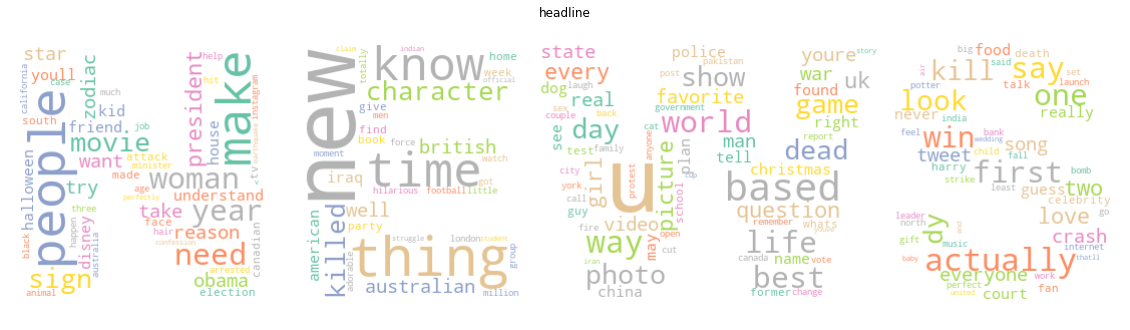

In [10]:
#you can find News_mask.PNG here https://www.kaggle.com/tarzon/input-img
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator 
from textblob import TextBlob, Word
# Join the different processed titles together.
long_string = ','.join(list(df['headline'].values))
mask = np.array(Image.open("News_mask.PNG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=mask).generate(long_string) 
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("news for all hedline.png", format="png") 
plt.title("headline");

plt.show()

####  for click and non-click

In [11]:
non_clickbait = df.loc[df['clickbait']==0]
clickbait  = df.loc[df['clickbait']==1]

In [12]:
non_clickbait = non_clickbait['headline'].str.cat(sep=' ')
clickbait = clickbait['headline'].str.cat(sep=' ')

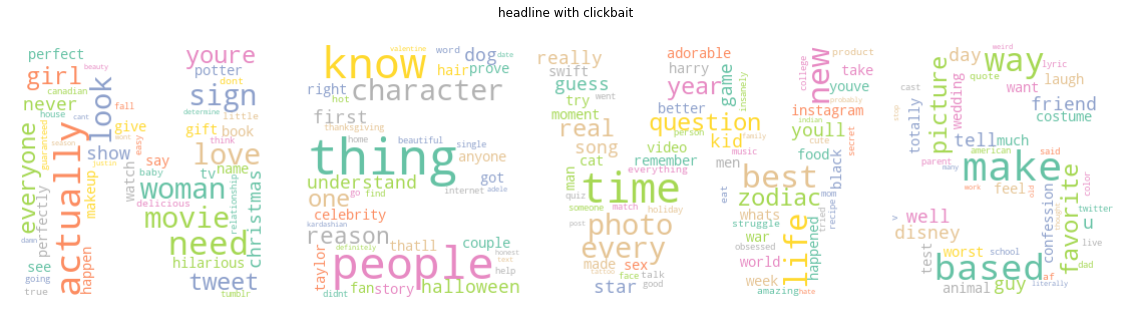

In [13]:
# Generate a word cloud image
mask = np.array(Image.open("News_mask.PNG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=mask).generate(clickbait) 
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("headline with clickbait.png", format="png") 
plt.title("headline with clickbait");

plt.show()

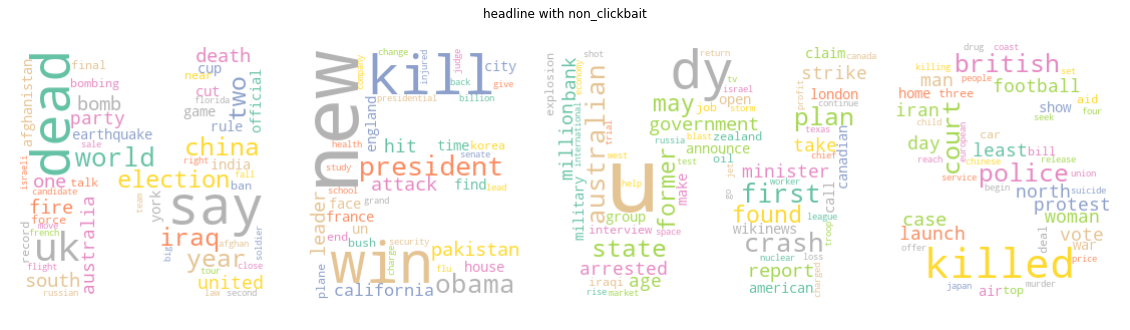

In [14]:
from PIL import Image

# Generate a word cloud image
from wordcloud import WordCloud, ImageColorGenerator

mask = np.array(Image.open("News_mask.PNG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=mask).generate(non_clickbait) 
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("headline with non_clickbait.png", format="png") 
plt.title("headline with non_clickbait");

plt.show()


# <a name=tp>Topic Modeling</a>

### LDA model

In [48]:
# Build LDA Model
#seed=100
#np.random.seed(seed)
lda_model = LatentDirichletAllocation(n_components=4,n_jobs = -1)
lda_output = lda_model.fit_transform(doc_word)

print(lda_model)                                      

LatentDirichletAllocation(n_components=4, n_jobs=-1)


In [49]:
# Define Search Param
#search_params = {'n_components': [4,5,6,7,8,9]}

# Init the Model
#lda = LatentDirichletAllocation()

# Init Grid Search Class
#model = RandomizedSearchCV(lda,param_distributions=search_params,cv = 10, random_state=0 , n_jobs = -1)

# Do the Grid Search
#model.fit(doc_word)

In [50]:
#print("Best Model's Params: ", model.best_params_)
#print("Best Estimator: ",model.best_estimator_)
#print("Best Score:  ", model.best_score_)

In [51]:
#best_lda=model.best_estimator_

#### The best LDA paramas is 4 

In [55]:
lda_output = lda_model.transform(doc_word)

# column names
topicnames = ['Entertainment','Breaking news','Lifestyle','Politics']

# index names
docnames = ["headline " + str(i) for i in range(len(df.headline))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Entertainment,Breaking news,Lifestyle,Politics,dominant_topic
headline 0,0.620000,0.130000,0.130000,0.130000,0
headline 1,0.090000,0.080000,0.750000,0.080000,2
headline 2,0.400000,0.460000,0.070000,0.070000,1
headline 3,0.620000,0.070000,0.070000,0.240000,0
headline 4,0.800000,0.060000,0.070000,0.070000,0
headline 5,0.240000,0.070000,0.610000,0.070000,2
headline 6,0.760000,0.080000,0.080000,0.080000,0
headline 7,0.690000,0.110000,0.090000,0.100000,0
headline 8,0.780000,0.070000,0.070000,0.070000,0
headline 9,0.620000,0.060000,0.250000,0.060000,0


### Results of LDA model

In [56]:
display_topics(lda_model, vectorizer.get_feature_names(), 15,topic_names=topicnames)


Topic: ' Entertainment '
thing, know, based, time, way, actually, make, people, best, sign, life, like, movie, zodiac, need

Topic: ' Breaking news '
kill, killed, dead, crash, laugh, attack, pakistan, police, bomb, iraq, uk, new, force, bombing, china

Topic: ' Lifestyle '
thing, new, people, know, need, australian, election, text, tell, question, like, make, actually, phone, didnt

Topic: ' Politics '
new, obama, state, court, president, month, dy, bank, case, year, united, plan, world, say, birth


In [21]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, doc_word, vectorizer, mds='tsne')
panel

In [22]:
df['topices'] = dominant_topic

In [23]:
df.loc[df['topices'] == 0, 'popular_topices'] = 'Entertainment'    
df.loc[df['topices'] == 1, 'popular_topices'] = 'Breaking news'
df.loc[df['topices'] == 2, 'popular_topices'] = 'Lifestyle' 
df.loc[df['topices'] == 3, 'popular_topices'] = 'Politics'

In [24]:
df

### save LDA results in csv file to do NLB classifications

In [25]:
#df.to_csv("dataBeforeMask.csv")

In [26]:
#df=df.loc[df['clickbait'] == 1]
#df

In [27]:
#df.to_csv("DataAfterMask.csv")

In [28]:
#df = pd.read_csv('dataBeforeMask.csv', index_col = 0)
#df

In [29]:
#df = pd.read_csv('DataAfterMask.csv', index_col = 0)
#df